In [1]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

## Dataset Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
dataset_dir = 'Dataset'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

assert abs(mean[0]*255 - 0.57119 * 255) < 0.1, "Red mean mismatch"
assert abs(mean[1]*255 - 0.57445 * 255) < 0.1, "Green mean mismatch"
assert abs(mean[2]*255 - 0.60537 * 255) < 0.1, "Blue mean mismatch"

assert abs(std[0]*255 - 0.11762 * 255) < 0.1, "Red std mismatch"
assert abs(std[1]*255 - 0.12342 * 255) < 0.1, "Green std mismatch"
assert abs(std[2]*255 - 0.11999 * 255) < 0.1, "Blue std mismatch"

print("\nBasic validation checks passed!")

In [2]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]

## Traffic Sign Dataset

### Data Augmentation

In [3]:
transform_album = A.Compose(
    [   
        A.Resize(32, 32),
        A.Affine(
            translate_percent=0.02,
            scale=(0.95, 1.05),
            fill=128,
            p=0.3
        ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=128,
            p=0.4
        ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.2
        ),
        A.RGBShift(
          r_shift_limit=2,
          g_shift_limit=2,
          b_shift_limit=2,
          p=0.2 
        ),
        A.GaussianBlur(
            blur_limit=(3, 7),
            p=0.2
        ),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            mean_range=(0.04, 0.06),
            p=0.2
        ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [4]:
transform_simple = A.Compose(
    [
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [5]:
transform_resize = A.Compose(
    [
        A.Resize(32, 32),
        ToTensorV2()
    ],
    p=1
)

In [6]:
root_dir = r'Dataset'
output_dir = r'Augmented_Dataset'
os.makedirs(output_dir, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [7]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [ ]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(output_dir, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(output_dir, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(output_dir)}")

In [ ]:
images_path_list = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir)}")

### Dataset Class

In [8]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self) -> int:
        return len(self.images_path_list)
    
    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [9]:
root_dir_dataset = r'Dataset'
root_dir_augmented = r'Augmented_Dataset'

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))
    
    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )
    
    for img_path in train_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)
        
    for img_path in test_paths:
        images_path_list_test.append(img_path)
        labels_path_list_test.append(cls_idx)

In [10]:
train_dataset = TrafficSignDB(
    images_path_list=images_path_list_train,
    labels_path_list=labels_path_list_train,
    transform=transform_simple
)

test_dataset = TrafficSignDB(
    images_path_list=images_path_list_test,
    labels_path_list=labels_path_list_test,
    transform=transform_simple
)

In [11]:
print("Class Mapping (idx -> class):")
print(train_dataset.idx_to_class)
print("\nTrain Dataset Files:")
for path, label in zip(images_path_list_train, labels_path_list_train):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")
print("\nTest Dataset Files:")
for path, label in zip(images_path_list_test, labels_path_list_test):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")

Class Mapping (idx -> class):
{0: 'barred_area', 1: 'cross_walk', 2: 'go_straight', 3: 'no_passing_zone_beginning', 4: 'parking_zone', 5: 'priority_over', 6: 'steep_hill_downhill', 7: 'steep_hill_uphill', 8: 'stop', 9: 'tunnel_beginning', 10: 'turn_left', 11: 'turn_right'}

Train Dataset Files:
Path: Augmented_Dataset\barred_area\frame_0001_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_03.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_04.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_05.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_03.png | Label: 0 | Cla

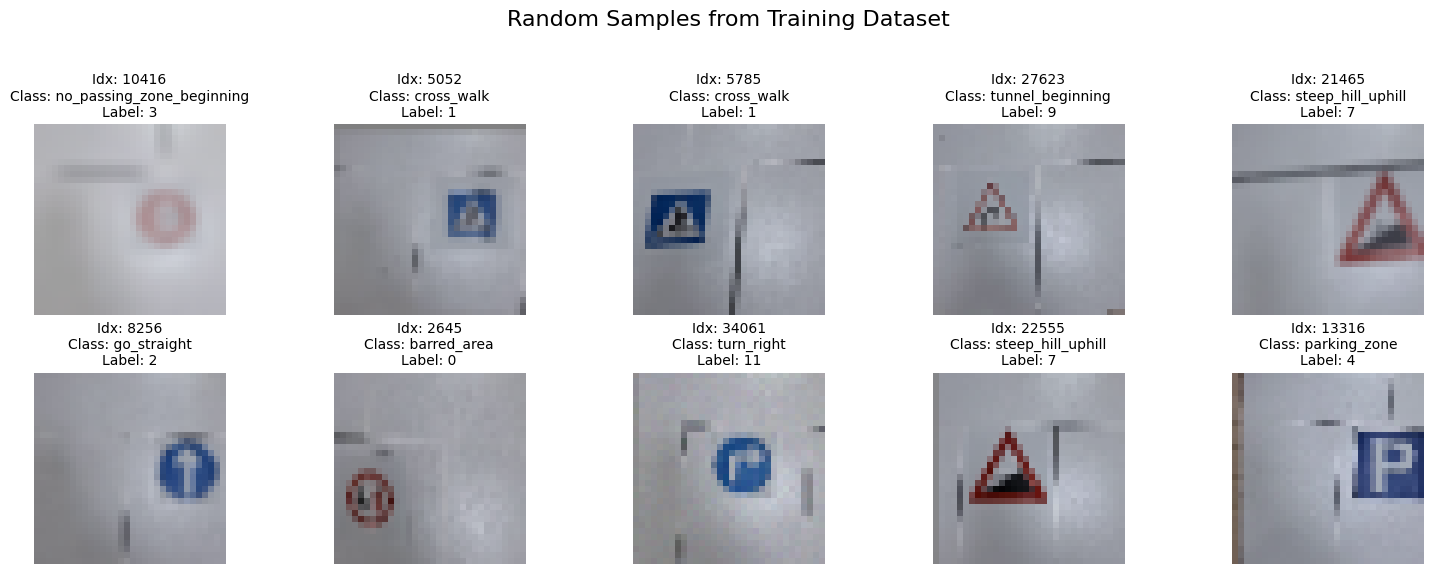

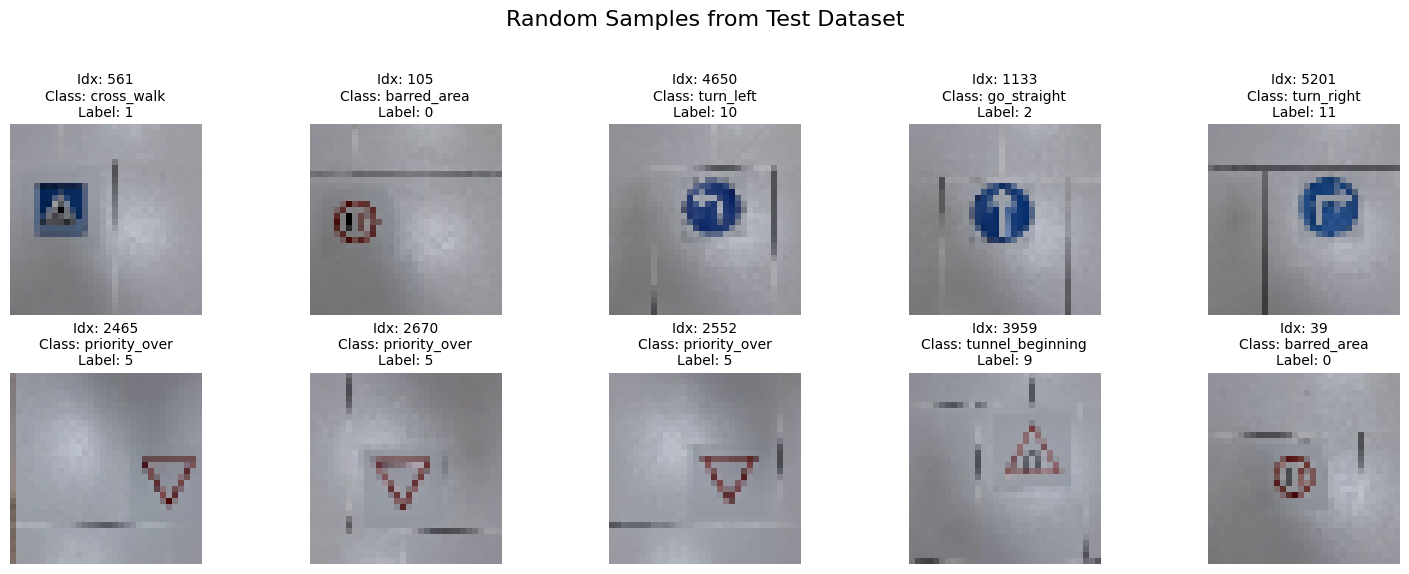

In [12]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def show_random_samples_subplot(dataset, num_samples=10, dataset_name="Dataset"):
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.get_class_name(label)
        if isinstance(image, torch.Tensor):
            image = denormalize_image(image, dataset_mean, dataset_std)
        axes[i].imshow(image)
        axes[i].set_title(f"Idx: {idx}\nClass: {class_name}\nLabel: {label}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f"Random Samples from {dataset_name}", fontsize=16)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95), w_pad=2)
    plt.show()

show_random_samples_subplot(train_dataset, num_samples=10, dataset_name="Training Dataset")
show_random_samples_subplot(test_dataset, num_samples=10, dataset_name="Test Dataset")

In [13]:
from collections import Counter

train_class_counts = Counter(labels_path_list_train)
test_class_counts = Counter(labels_path_list_test)
train_total = len(images_path_list_train)
test_total = len(images_path_list_test)

print("\nTraining Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = train_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")

print("\nTest Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = test_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")
    
print(f"\nTraining Dataset Size: {train_total} samples")
print(f"Test Dataset Size: {test_total} samples")
print(f"Total Combined Size: {train_total + test_total} samples")


Training Dataset Class Distribution:
Class 'barred_area' (Index 0): 3255 samples
Class 'cross_walk' (Index 1): 3114 samples
Class 'go_straight' (Index 2): 2646 samples
Class 'no_passing_zone_beginning' (Index 3): 2990 samples
Class 'parking_zone' (Index 4): 2615 samples
Class 'priority_over' (Index 5): 3073 samples
Class 'steep_hill_downhill' (Index 6): 2355 samples
Class 'steep_hill_uphill' (Index 7): 2626 samples
Class 'stop' (Index 8): 2953 samples
Class 'tunnel_beginning' (Index 9): 3218 samples
Class 'turn_left' (Index 10): 3109 samples
Class 'turn_right' (Index 11): 2979 samples

Test Dataset Class Distribution:
Class 'barred_area' (Index 0): 501 samples
Class 'cross_walk' (Index 1): 480 samples
Class 'go_straight' (Index 2): 408 samples
Class 'no_passing_zone_beginning' (Index 3): 460 samples
Class 'parking_zone' (Index 4): 403 samples
Class 'priority_over' (Index 5): 473 samples
Class 'steep_hill_downhill' (Index 6): 363 samples
Class 'steep_hill_uphill' (Index 7): 404 samples

## Training the Model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.905023..2.0164244].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8908525..1.3457108].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.596416..3.5139818].



Dataset Verification:
Total samples: 34933
Sample paths: ['Augmented_Dataset\\barred_area\\frame_0001_aug_01.png', 'Augmented_Dataset\\barred_area\\frame_0001_aug_02.png', 'Augmented_Dataset\\barred_area\\frame_0001_aug_03.png']


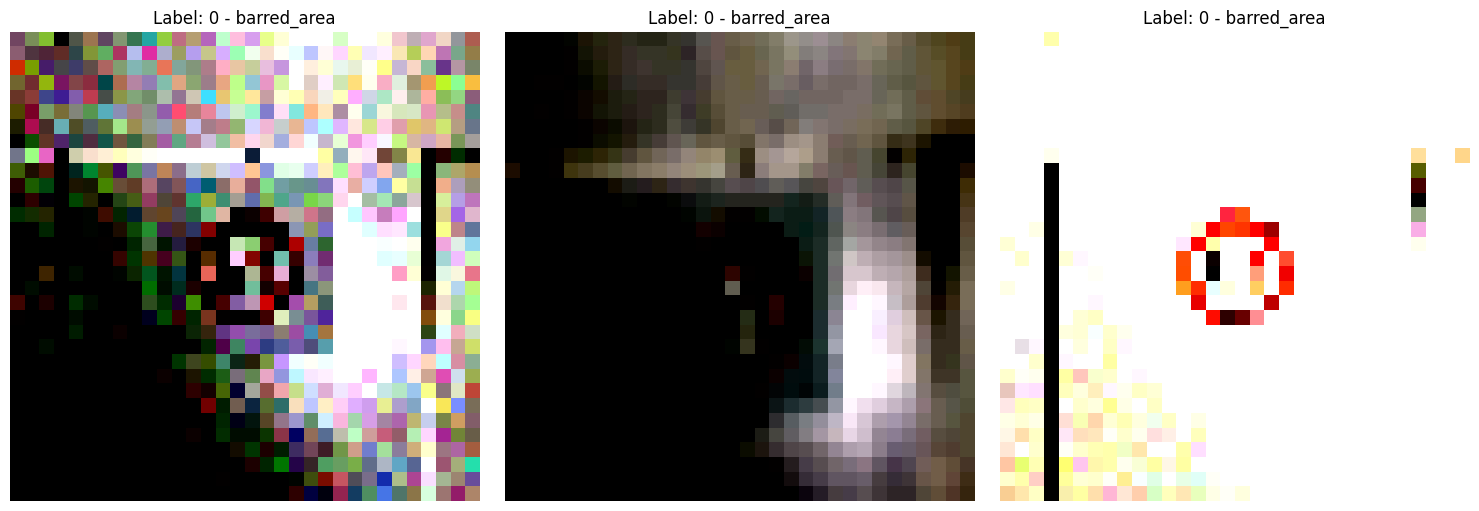

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4797258..1.4602664].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.8864784..1.5792168].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.1852891..1.394836].



Dataset Verification:
Total samples: 5381
Sample paths: ['Dataset\\barred_area\\frame_0449.png', 'Dataset\\barred_area\\frame_0487.png', 'Dataset\\barred_area\\frame_0216.png']


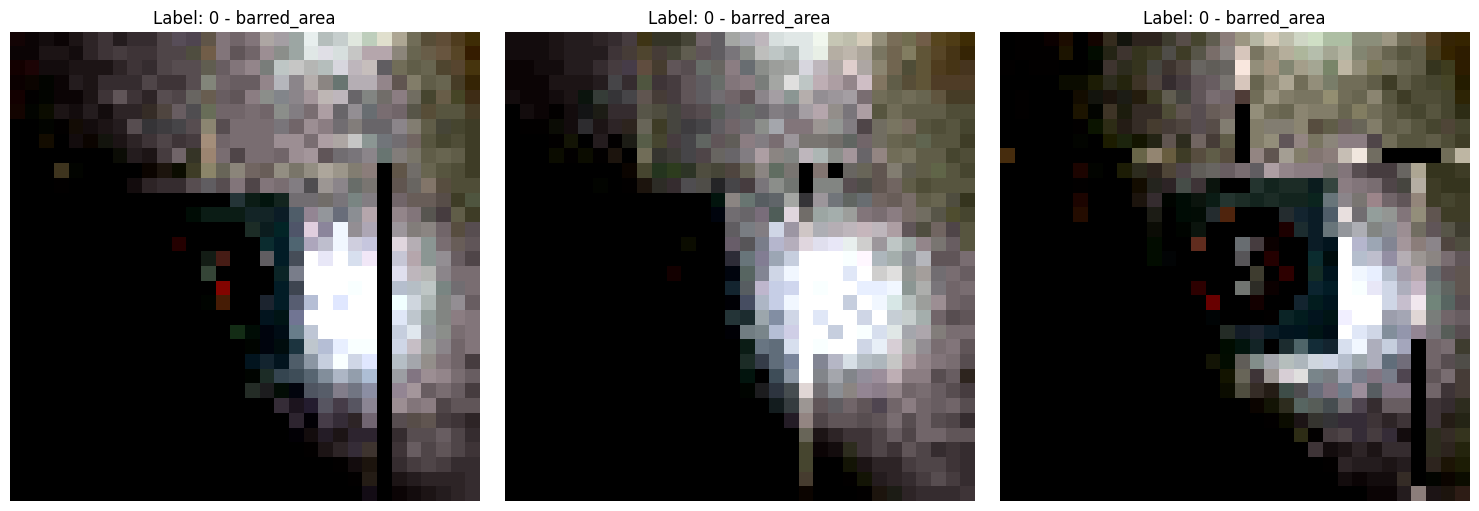

In [15]:
def verify_dataset(dataset, num_samples=3):
    print("\nDataset Verification:")
    print(f"Total samples: {len(dataset)}")
    print(f"Sample paths: {dataset.images_path_list[:3]}")
    
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title(f"Label: {label} - {dataset.get_class_name(label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

verify_dataset(train_dataset)
verify_dataset(test_dataset)

In [16]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(TrafficSignCNN, self).__init__()
        
        self.conv0 = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=1, padding=0)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)
        
        self.dropout = nn.Dropout(0.5)

        flattened_size = 8192 + 4096 + 2048
        
        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        print(f"Input shape: {x.shape}") if self.training else None
        
        x = F.relu(self.conv0(x))

        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x2 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,32,16,16)
        x2 = self.dropout(x2)
        

        x = F.relu(self.conv3(x2))

        x = F.relu(self.conv4(x))
        x4 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,64,8,8)
        x4 = self.dropout(x4)
        
        x = F.relu(self.conv5(x4))

        x = F.relu(self.conv6(x))
        x6 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,128,4,4)
        x6 = self.dropout(x6)
        
        flat2 = x2.view(x2.size(0), -1)
        flat4 = x4.view(x4.size(0), -1)
        flat6 = x6.view(x6.size(0), -1)
        
        x_concat = torch.cat((flat2, flat4, flat6), dim=1)  # (B, 14336)
        
        x = F.relu(self.fc1(x_concat))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)
        
        return logits

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(dataloader.dataset), correct / total

In [20]:
def check_dimensions(loader):
    for inputs, _ in loader:
        print(f"Batch dimensions: {inputs.shape}")
        print(f"Data range: {inputs.min().item()} - {inputs.max().item()}")
        break

print("\nChecking training data dimensions:")
check_dimensions(train_loader)
print("\nChecking validation data dimensions:")
check_dimensions(test_loader)


Checking training data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -4.858880996704102 - 3.61405611038208

Checking validation data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -5.01733922958374 - 1.846081018447876


In [21]:
def train_model(model, criterion, optimizer, num_epochs=10):
    writer = SummaryWriter()  # TensorBoard logging
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        # Create one progress bar for the epoch
        tepoch = tqdm(
            train_loader,
            unit="batch",
            leave=True,
            desc=f"Epoch {epoch+1}/{num_epochs}",
            dynamic_ncols=True,
            # ncols=100,
            bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
        )
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            tepoch.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100.*correct/total:.2f}")
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)
        
        val_loss, val_acc = evaluate_model(model, criterion, test_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    writer.close()
    return model

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=len(class_names), input_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Using device: cuda


In [ ]:
trained_model = train_model(model, criterion, optimizer, num_epochs=10)

## Validation

In [23]:
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

In [24]:
class_names = [
    'barred_area',
    'cross_walk',
    'go_straight',
    'no_passing_zone_beginning',
    'parking_zone',
    'priority_over',
    'steep_hill_downhill',
    'steep_hill_uphill',
    'stop',
    'tunnel_beginning',
    'turn_left',
    'turn_right'
]

In [ ]:
def live_test(model_path):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Transformations (must match training)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=dataset_mean, std=dataset_std)
    ])
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Couldn't read frame")
                break
                
            # Process frame
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            tensor_img = transform(rgb).unsqueeze(0).to(device)
            
            # Inference
            with torch.no_grad():
                outputs = model(tensor_img)
                _, pred = torch.max(outputs, 1)
                sign_name = class_names[pred.item()]
            
            # Display option 1: Save to file (works everywhere)
            output_frame = frame.copy()
            cv2.putText(output_frame, sign_name, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imwrite('latest_detection.jpg', output_frame)
            
            # Display option 2: For Jupyter notebooks
            try:
                from IPython.display import display, Image, clear_output
                _, buffer = cv2.imencode('.jpg', output_frame)
                display(Image(data=buffer.tobytes()))
                clear_output(wait=True)
            except ImportError:
                pass
            
            # Exit condition (no need for waitKey)
            # Press 'q' in terminal/notebook to stop
            # Or implement your own stopping condition
            
    except KeyboardInterrupt:
        print("Stopping...")
    finally:
        cap.release()
        print("Webcam released")

In [ ]:
live_test("best_model.pth")

In [ ]:
def predict_image(model, image_path, transform):
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Convert color
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transforms correctly
    if isinstance(transform, A.Compose):
        # Albumentations style
        transformed = transform(image=rgb)
        input_tensor = transformed["image"].unsqueeze(0).to(device)
    else:
        # PyTorch transforms style
        input_tensor = transform(rgb).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        class_idx = pred.item()
        confidence = torch.nn.functional.softmax(outputs, dim=1)[0][class_idx].item()
    
    return class_idx, confidence

def test_single_image(model_path, image_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path)
    transform = transform_simple
    
    try:
        class_idx, confidence = predict_image(model, image_path, transform)
        print(f"Predicted: {class_names[class_idx]} (Confidence: {confidence:.2%})")
        
        # Display
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{class_names[class_idx]} ({confidence:.1%})")
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error: {str(e)}")

In [26]:
model_path = "best_model.pth"
test_image_path = "test.png"

test_single_image(model_path, test_image_path)

KeyError: 'You have to pass data to augmentations as named arguments, for example: aug(image=image)'